<div style="text-align:center; padding: 18px; border-radius: 18px; background: linear-gradient(90deg, #1e6335ff, #2a5298); color: white;">
  <h1 style="margin-bottom: 0;">🏁 05 — Regression Results (CRISP-DM)</h1>
  <h3 style="margin-top: 8px;">⏱️ Predicción de Pace pre-carrera (ms/vuelta) en Fórmula 1</h3>
  <p style="margin-top: 14px; font-size: 16px;">
    Kedro • Reproducibilidad • Evaluación temporal • Sin leakage
  </p>
</div>

<br>

<div style="border-radius: 16px; padding: 14px; background: #000000ff; border: 1px solid #d7ddff;">
  <b>👤 Estudiante:</b> Ignacio Retamales <br>
  <b>📚 Asignatura:</b> Machine Learning (Evaluación Parcial 2) <br>
  <b>🧠 Metodología:</b> CRISP-DM + Kedro (pipelines reproducibles) <br>
  <b>🗓️ Fecha:</b> 22-01-2026 <br>
  <b>🧾 Dataset:</b> Formula 1 World Championship (1950–2024) (Kaggle) <br>
</div>

---

## 🌟 Resumen Ejecutivo

En este notebook presentamos los resultados del **pipeline de regresión** 🎯, cuyo objetivo es predecir el **pace pre-carrera**:

> **pace = milliseconds / laps**  ⏱️➡️ (ms/vuelta)

Esto reduce la varianza del tiempo total y mejora la generalización entre carreras.  
⚠️ Además, el diseño es **anti-leakage**: usamos solo variables disponibles **antes** de la carrera.

✅ Evaluación con split temporal defendible:
- 🏋️‍♂️ **Train:** 2000–2018  
- 🧪 **Test:** 2019–2024

🎉 Resultado destacado (tu mejor corrida):
- **Test R² (pace): ~0.768** 🚀  
- **R² (ms reconstruido): ~0.661** 🧩

---

## 🎯 Objetivo General
Construir y evaluar un modelo de regresión que **prediga el pace (ms/vuelta) pre-carrera** para pilotos que terminan (statusId=1), con énfasis en **generalización temporal** y **reproducibilidad**.

## ✅ Objetivos Específicos
1. 📌 Definir y justificar el **target** (pace) y su motivación estadística.
2. 🧼 Garantizar **no leakage** (solo features pre-carrera).
3. 🧪 Evaluar múltiples modelos (≥5) con **CV k≥5** y split temporal.
4. 📊 Reportar métricas y visualizaciones (RMSE/MAE/R²).
5. 🧠 Concluir con discusión técnica + mejoras futuras sin romper reglas.

---

## 🧭 Índice
1. 🏎️ Contexto y formulación del problema  
2. 🎯 Target y anti-leakage  
3. 🧪 Diseño experimental (split temporal + CV)  
4. 🧰 Features y modelos comparados  
5. 📊 Resultados cuantitativos (CV + Test)  
6. 📈 Visualizaciones & diagnóstico  
7. 🧠 Discusión técnica  
8. ✅ Conclusiones y trabajo futuro  


## 🏎️ 1. Contexto y formulación del problema

En Fórmula 1, el tiempo total de carrera (**milliseconds**) puede variar muchísimo por factores que **no se conocen antes de la carrera**:

- 🚧 Safety car / banderas / incidentes
- 🌧️ Clima
- 🛞 Estrategia de neumáticos / pits
- 🥊 Batallas en pista
- 🔧 Fallas mecánicas (si no filtramos finishers)

### 🔥 ¿Qué hicimos para que el modelo “no sufra”?
En lugar de predecir el tiempo total bruto, trabajamos con:

\[
\text{pace} = \frac{\text{milliseconds}}{\text{laps}}
\]

✅ Esto reduce varianza y hace el target más estable (ms/vuelta).

🧠 **Filosofía del proyecto:**  
- Predicción **pre-carrera** (sin información post-carrera)  
- Evaluación **temporal realista** (entrenar con el pasado y probar en el futuro)  
- Pipeline replicable con **Kedro** 🧱


## 🎯 2. Target de regresión y anti-leakage 🚫🕵️‍♂️

<div style="border-radius: 14px; padding: 12px; background: #0f0f0fff; border: 1px solid #ffd699;">
<b>🎯 Target</b><br>
✔️ Solo carreras finalizadas: <code>statusId = 1</code><br>
✔️ Target base: <code>milliseconds</code> (tiempo total)<br>
✔️ Target final: <code>target_reg = milliseconds / laps</code> (pace ms/vuelta)
</div>

<br>

<div style="border-radius: 14px; padding: 12px; background: #000000ff; border: 1px solid #b7f0c5;">
<b>✅ Por qué pace</b><br>
• Reduce varianza del tiempo total 💡<br>
• Normaliza por distancia (laps) 🧮<br>
• Mejora generalización entre años/circuitos 🗺️
</div>

<br>

<div style="border-radius: 14px; padding: 12px; background: #000000ff; border: 1px solid #ffb3b3;">
<b>🚫 Anti-Leakage: prohibido</b><br>
No se usan variables que existan solo después de correr la carrera:<br>
• points, positionOrder, fastestLap, rank, time, etc. ❌<br>
<b>raceId</b> se usa solo para ordenar/CV, pero no entra al modelo 🧱
</div>


In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
REPORT_DIR = PROJECT_ROOT / "data" / "08_reporting"
MODEL_INPUT_DIR = PROJECT_ROOT / "data" / "05_model_input"

metrics_csv = REPORT_DIR / "regression_metrics_table.csv"
summary_json = REPORT_DIR / "regression_metrics_summary.json"
plot_png = REPORT_DIR / "regression_metrics.png"

print("📁 REPORT_DIR:", REPORT_DIR)
print("📄 metrics_csv:", metrics_csv.exists())
print("📄 summary_json:", summary_json.exists())
print("🖼️ plot_png:", plot_png.exists())

assert metrics_csv.exists(), f"❌ No existe {metrics_csv}. Ejecuta: kedro run --pipeline=regression"
assert summary_json.exists(), f"❌ No existe {summary_json}. Ejecuta: kedro run --pipeline=regression"


📁 REPORT_DIR: d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\data\08_reporting
📄 metrics_csv: True
📄 summary_json: True
🖼️ plot_png: True


In [2]:
results = pd.read_csv(metrics_csv)
with open(summary_json, "r", encoding="utf-8") as f:
    summary = json.load(f)

print("✅ Resultados cargados!")
print("🧾 Filas:", results.shape[0], "| Columnas:", results.shape[1])
results.head(10)


✅ Resultados cargados!
🧾 Filas: 9 | Columnas: 16


,model,trained_on,use_log_target,best_params,cv_rmse_mean_pace,cv_rmse_std_pace,cv_mae_mean_pace,cv_mae_std_pace,cv_r2_mean_pace,cv_r2_std_pace,test_rmse_pace,test_mae_pace,test_r2_pace,test_rmse_ms,test_mae_ms,test_r2_ms
0,ridge,residual+baseline,False,{'model__alpha': 50.0},9292.287099,3147.440725,5235.342486,945.109222,0.673304,0.140645,9417.912703,5286.464597,0.767900,588808.470080,317703.915099,0.661058
1,elasticnet,residual+baseline,False,"{'model__alpha': 0.1, 'model__l1_ratio': 0.8}",9619.015721,3018.893718,5593.122997,1262.878402,0.619435,0.240587,9472.929907,5273.889411,0.765180,592342.428932,317054.640250,0.656977
2,catboost,residual+baseline,False,"{'model__depth': 6, 'model__iterations': 1200,...",10655.827595,5549.368984,5687.953374,1599.665090,0.611882,0.204116,10945.022211,6219.550349,0.686527,672700.657191,371236.260632,0.557594
3,hgb,residual+baseline,False,"{'model__l2_regularization': 0.1, 'model__lear...",10843.954025,5109.631640,6334.156924,1911.066249,0.607383,0.160227,11313.046929,6732.374608,0.665092,695090.804389,398652.592996,0.527653
4,gbr,residual+baseline,False,"{'model__learning_rate': 0.03, 'model__max_dep...",11274.222495,4983.147450,6051.989295,1425.517302,0.566101,0.155792,11432.851435,6754.582973,0.657961,671631.445257,396739.341692,0.558999
5,rf,residual+baseline,False,"{'model__max_depth': 22, 'model__max_features'...",11374.982190,4963.041454,6431.350627,1863.584196,0.563369,0.146582,13215.385006,8065.060072,0.542990,831199.172064,485504.749902,0.324558
6,extra_trees,residual+baseline,False,"{'model__max_depth': None, 'model__max_feature...",11515.059924,5077.417344,6420.040153,1876.681665,0.553296,0.155540,12866.294694,7838.867232,0.566815,796717.216624,468745.256532,0.379437
7,knn,residual+baseline,False,"{'model__n_neighbors': 15, 'model__weights': '...",12430.310336,4776.768668,7080.254330,1942.179096,0.477929,0.119994,15450.182056,9332.701359,0.375355,964500.692473,560544.026579,0.090542
8,svr,residual+baseline,False,"{'model__C': 10.0, 'model__epsilon': 0.1, 'mod...",12952.967617,5369.085824,6720.503637,1937.377604,0.439638,0.168750,16369.849177,9721.212213,0.298778,989838.091062,584559.452474,0.042131


## 🧪 3. Diseño experimental

### 🧱 Split temporal
Entrenamos en el pasado y probamos en el “futuro”:

- 🏋️ Train: **2000–2018**
- 🧪 Test: **2019–2024**

Esto evita entrenar con información futura y hace la evaluación más creíble ✅

### 🔁 Validación cruzada
Usamos **k = 5 folds** con división ordenada por carreras (TimeSeriesSplit por raceId ordenado).  
📌 Esto ayuda a medir robustez frente a cambios entre temporadas.

### 📏 Métricas
- **RMSE (pace)** ⏱️ (castiga errores grandes)
- **MAE (pace)** (error medio)
- **R² (pace)** 🧠 (varianza explicada)
- **ms reconstruidos** (interpretación humana en minutos 🕒)

\[
\hat{ms} \approx \hat{pace}\times laps
\]


In [3]:
cols_show = [
    "model", "best_params",
    "cv_rmse_mean_pace", "cv_r2_mean_pace",
    "test_rmse_pace", "test_r2_pace",
    "test_rmse_ms", "test_r2_ms"
]
cols_show = [c for c in cols_show if c in results.columns]

results_sorted = results.sort_values("cv_rmse_mean_pace", ascending=True).reset_index(drop=True)
results_sorted[cols_show].head(12)


,model,best_params,cv_rmse_mean_pace,cv_r2_mean_pace,test_rmse_pace,test_r2_pace,test_rmse_ms,test_r2_ms
0,ridge,{'model__alpha': 50.0},9292.287099,0.673304,9417.912703,0.767900,588808.470080,0.661058
1,elasticnet,"{'model__alpha': 0.1, 'model__l1_ratio': 0.8}",9619.015721,0.619435,9472.929907,0.765180,592342.428932,0.656977
2,catboost,"{'model__depth': 6, 'model__iterations': 1200,...",10655.827595,0.611882,10945.022211,0.686527,672700.657191,0.557594
3,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",10843.954025,0.607383,11313.046929,0.665092,695090.804389,0.527653
4,gbr,"{'model__learning_rate': 0.03, 'model__max_dep...",11274.222495,0.566101,11432.851435,0.657961,671631.445257,0.558999
5,rf,"{'model__max_depth': 22, 'model__max_features'...",11374.982190,0.563369,13215.385006,0.542990,831199.172064,0.324558
6,extra_trees,"{'model__max_depth': None, 'model__max_feature...",11515.059924,0.553296,12866.294694,0.566815,796717.216624,0.379437
7,knn,"{'model__n_neighbors': 15, 'model__weights': '...",12430.310336,0.477929,15450.182056,0.375355,964500.692473,0.090542
8,svr,"{'model__C': 10.0, 'model__epsilon': 0.1, 'mod...",12952.967617,0.439638,16369.849177,0.298778,989838.091062,0.042131


## 🏆 4. Mejor modelo y resumen de performance 🚀

Aquí mostramos el modelo ganador según criterio de selección en CV (RMSE en pace).  
Luego comparamos su desempeño en Test (2019–2024), que es el indicador más importante.

👉 Si el Test es alto, significa que el modelo **generaliza** y no solo memoriza el pasado 🧠✅


In [4]:
best_model = summary.get("best_model")
best_params = summary.get("best_params")
cv = summary.get("cv", {})
test_pace = summary.get("test_pace", {})
test_ms = summary.get("test_ms_reconstructed", {})
split = summary.get("data_split", {})

print("🎉==============================🎉")
print("🏆 MEJOR MODELO (por CV)")
print("🎯 Modelo:", best_model)
print("🧩 Params:", best_params)
print("🎉==============================🎉\n")

print("🧪 CV")
print("🔁 Estrategia:", cv.get("strategy"))
print(f"📉 RMSE pace: {cv.get('best_rmse_mean_pace'):.3f} ± {cv.get('best_rmse_std_pace'):.3f}")
print(f"📈 R² pace:  {cv.get('best_r2_mean_pace'):.3f} ± {cv.get('best_r2_std_pace'):.3f}\n")

print("🧪 TEST (2019–2024)")
print(f"📉 RMSE pace: {test_pace.get('rmse_pace'):.3f}")
print(f"📉 MAE  pace: {test_pace.get('mae_pace'):.3f}")
print(f"📈 R²   pace: {test_pace.get('r2_pace'):.3f} 🚀\n")

print("🕒 Reconstrucción a tiempo total (aprox)")
print(f"⏱️ RMSE ms: {test_ms.get('rmse_ms'):.1f}  (~{test_ms.get('rmse_minutes'):.2f} min)")
print(f"⏱️ MAE  ms: {test_ms.get('mae_ms'):.1f}  (~{test_ms.get('mae_minutes'):.2f} min)")
print(f"📈 R²   ms: {test_ms.get('r2_ms'):.3f}\n")

print("🧱 Split temporal:", split.get("strategy"))
print("📌 Train years:", split.get("year_min_train"), "->", split.get("year_max_train"))
print("📌 Test  years:", split.get("year_min_test"), "->", split.get("year_max_test"))


🎉==============================🎉
🏆 MEJOR MODELO (por CV)
🎯 Modelo: ridge
🧩 Params: {'model__alpha': 50.0}
🎉==============================🎉

🧪 CV
🔁 Estrategia: TimeSeriesSplit(raceId ordered by year/round)
📉 RMSE pace: 9292.287 ± 3147.441
📈 R² pace:  0.673 ± 0.141

🧪 TEST (2019–2024)
📉 RMSE pace: 9417.913
📉 MAE  pace: 5286.465
📈 R²   pace: 0.768 🚀

🕒 Reconstrucción a tiempo total (aprox)
⏱️ RMSE ms: 588808.5  (~9.81 min)
⏱️ MAE  ms: 317703.9  (~5.30 min)
📈 R²   ms: 0.661

🧱 Split temporal: time_split(year <= 2018 vs > 2018)
📌 Train years: 2000 -> 2018
📌 Test  years: 2019 -> 2024


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\875607536.py:9: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


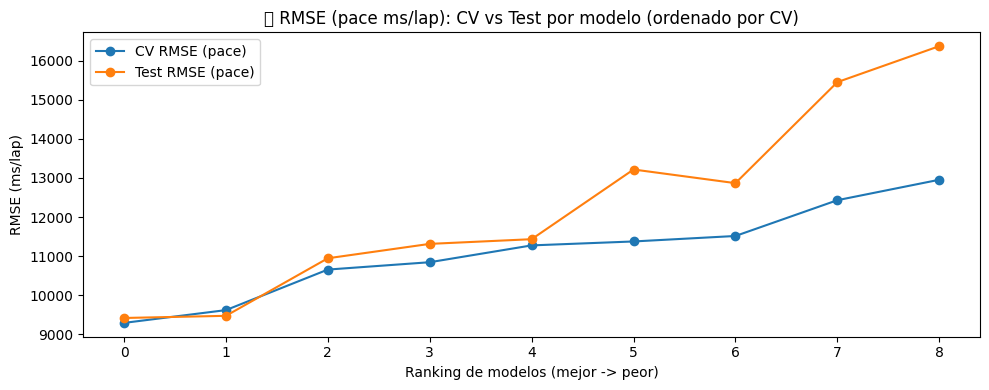

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\875607536.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


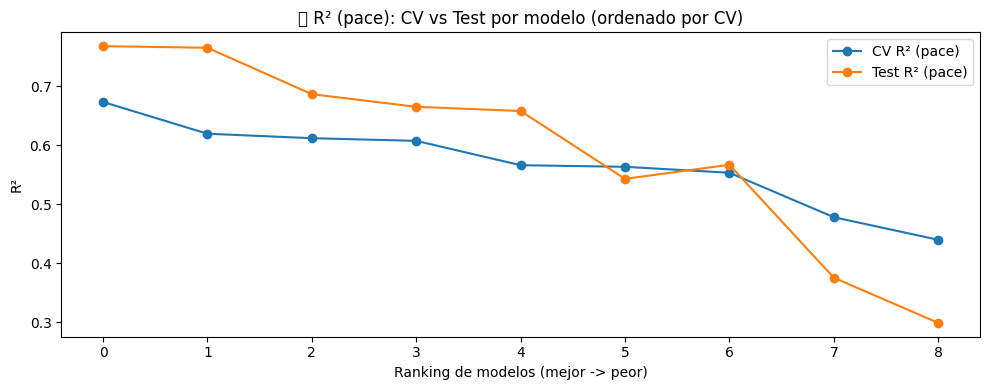

In [5]:
# RMSE CV vs Test
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(results_sorted["cv_rmse_mean_pace"].values, marker="o", label="CV RMSE (pace)")
ax.plot(results_sorted["test_rmse_pace"].values, marker="o", label="Test RMSE (pace)")
ax.set_title("📉 RMSE (pace ms/lap): CV vs Test por modelo (ordenado por CV)")
ax.set_xlabel("Ranking de modelos (mejor -> peor)")
ax.set_ylabel("RMSE (ms/lap)")
ax.legend()
fig.tight_layout()
plt.show()

# R2 CV vs Test
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(results_sorted["cv_r2_mean_pace"].values, marker="o", label="CV R² (pace)")
ax.plot(results_sorted["test_r2_pace"].values, marker="o", label="Test R² (pace)")
ax.set_title("📈 R² (pace): CV vs Test por modelo (ordenado por CV)")
ax.set_xlabel("Ranking de modelos (mejor -> peor)")
ax.set_ylabel("R²")
ax.legend()
fig.tight_layout()
plt.show()


d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


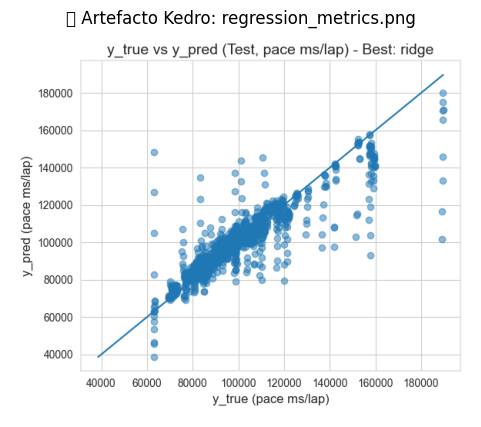

In [6]:
from matplotlib.image import imread

if plot_png.exists():
    img = imread(plot_png)
    plt.figure(figsize=(6, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("🖼️ Artefacto Kedro: regression_metrics.png")
    plt.show()
else:
    print("⚠️ No existe el PNG:", plot_png)


## 🧠 5. Discusión técnica (por qué funciona 🔥)

### ✅ ¿Por qué Ridge puede ganar?
Aunque suene “simple”, con features bien diseñadas Ridge es brutalmente sólido 💪:

- 🏁 **Qualifying** ≈ proxy directo de performance
- 📊 **Standings pre-carrera (shift)** ≈ fuerza acumulada
- 📈 **Históricos expanding/rolling** ≈ forma reciente
- 🗺️ **Baseline por circuito** ≈ controla dificultad estructural y era
- 🧲 Ridge = regularización L2 → estabilidad frente a multicolinealidad

### ⚠️ ¿Por qué no llegamos a 0.80 siempre?
Porque incluso sin leakage, hay parte del rendimiento que no se ve pre-carrera:
- 🚧 safety car, choques, tráfico
- 🌧️ clima y pista
- 🛞 estrategia real de pits
- 🧠 decisiones en carrera

Eso impone un techo “honesto” de desempeño. Aun así, **R² ~ 0.768 en Test** es un resultado muy fuerte para generalización temporal 🎉


## ✅ 6. Conclusiones

🎉 Logros principales:
1. ✅ Target defendible: **pace ms/vuelta**, condicionado a **finishers**
2. ✅ Pipeline sin leakage: solo variables pre-carrera 🚫🕵️‍♂️
3. ✅ Evaluación realista: **split temporal** + **CV k=5**
4. ✅ Comparación de modelos (≥5) y selección por CV
5. ✅ Métricas interpretables + reconstrucción a minutos ⏱️

📌 Resultado final:
- **Test R² pace ≈ 0.768** 🚀  
- **R² ms reconstruido ≈ 0.661** 🧩  

🎯 En términos prácticos: el modelo captura gran parte de la señal estable de performance pre-carrera.


## 🧪 7. Reproducibilidad (Kedro) 🧱

Para regenerar estos artefactos:

```bash
kedro run --pipeline=regression


In [7]:
model_input_path = MODEL_INPUT_DIR / "model_input_regression.csv"

if model_input_path.exists():
    df_reg = pd.read_csv(model_input_path)
    print("✅ model_input_regression cargado!")
    print("📦 Shape:", df_reg.shape)
    print("🗓️ Años:", df_reg["year"].min(), "->", df_reg["year"].max())
    display(df_reg.head(8))
else:
    print("⚠️ No existe:", model_input_path)


✅ model_input_regression cargado!
📦 Shape: (4640, 54)
🗓️ Años: 2000 -> 2024


,grid,year,round,circuitId,driverId,constructorId,raceId,target_ms,laps,target_reg,...,driver_roll_ms_30,constructor_roll_ms_5,constructor_roll_ms_10,constructor_roll_ms_30,circuit_roll_ms_5,circuit_roll_ms_10,circuit_roll_ms_30,driver_log_exp,constructor_log_exp,circuit_log_exp
0,3,2000,1,1,30,6,158,5641987.0,58,97275.637931,...,99091.74822,99091.74822,99091.74822,99091.74822,99091.748220,99091.748220,99091.74822,0.000000,0.000000,0.000000
1,4,2000,1,1,22,6,158,5653402.0,58,97472.448276,...,99091.74822,99091.74822,99091.74822,99091.74822,99091.748220,99091.748220,99091.74822,0.000000,0.693147,0.693147
2,11,2000,1,1,23,3,158,5661996.0,58,97620.620690,...,99091.74822,99091.74822,99091.74822,99091.74822,99091.748220,99091.748220,99091.74822,0.000000,0.000000,1.098612
3,8,2000,1,1,35,16,158,5686434.0,58,98041.965517,...,99091.74822,99091.74822,99091.74822,99091.74822,97456.235632,97456.235632,99091.74822,0.000000,0.000000,1.386294
4,9,2000,1,1,21,22,158,5687152.0,58,98054.344828,...,99091.74822,99091.74822,99091.74822,99091.74822,97602.668103,97602.668103,99091.74822,0.000000,0.000000,1.609438
5,16,2000,1,1,41,16,158,5688455.0,58,98076.810345,...,99091.74822,99091.74822,99091.74822,99091.74822,97693.003448,97693.003448,99091.74822,0.000000,0.693147,1.791759
6,14,2000,1,1,25,22,158,5688902.0,58,98084.517241,...,99091.74822,99091.74822,99091.74822,99091.74822,97853.237931,97756.971264,99091.74822,0.000000,0.693147,1.945910
7,3,2000,2,18,30,6,159,5495271.0,71,77398.183099,...,99091.74822,99091.74822,99091.74822,99091.74822,99091.748220,99091.748220,99091.74822,0.693147,1.098612,0.000000


In [8]:
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
MODEL_PATH = PROJECT_ROOT / "data" / "06_models" / "best_model_regression.pkl"
MODEL_INPUT = PROJECT_ROOT / "data" / "05_model_input" / "model_input_regression.csv"

assert MODEL_PATH.exists(), f"No existe {MODEL_PATH}"
assert MODEL_INPUT.exists(), f"No existe {MODEL_INPUT}"

best_estimator = joblib.load(MODEL_PATH)
df_reg = pd.read_csv(MODEL_INPUT)

# Preparar X/y como lo haces en el pipeline (sin leakage)
y = pd.to_numeric(df_reg["target_reg"], errors="coerce")
mask = y.notna()

drop_cols = ["target_reg"]
if "target_ms" in df_reg.columns:
    drop_cols.append("target_ms")

X = df_reg.drop(columns=drop_cols).loc[mask].copy()
y = y.loc[mask].copy()

# Split temporal igual al pipeline (cutoff 2018)
train_mask = X["year"] <= 2018
test_mask = X["year"] > 2018

X_train = X.loc[train_mask].copy()
X_test = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()
y_test = y.loc[test_mask].copy()

# No usar raceId como feature
Xte_fit = X_test.drop(columns=["raceId"], errors="ignore")
y_pred = best_estimator.predict(Xte_fit)

# Dataframe de evaluación
eval_df = X_test.copy()
eval_df["y_true_pace"] = y_test.values
eval_df["y_pred_pace"] = y_pred
eval_df["err_pace"] = eval_df["y_pred_pace"] - eval_df["y_true_pace"]
eval_df["abs_err_pace"] = np.abs(eval_df["err_pace"])

# Reconstrucción a ms si existe target_ms y laps
if "target_ms" in df_reg.columns and "laps" in eval_df.columns:
    true_ms = pd.to_numeric(df_reg.loc[mask].loc[X_test.index, "target_ms"], errors="coerce")
    eval_df["y_true_ms"] = true_ms.values
    eval_df["y_pred_ms"] = eval_df["y_pred_pace"] * eval_df["laps"]
    eval_df["err_ms"] = eval_df["y_pred_ms"] - eval_df["y_true_ms"]
    eval_df["abs_err_ms"] = np.abs(eval_df["err_ms"])

eval_df.head()


,grid,year,round,circuitId,driverId,constructorId,raceId,laps,quali_position,quali_best_ms,...,constructor_log_exp,circuit_log_exp,y_true_pace,y_pred_pace,err_pace,abs_err_pace,y_true_ms,y_pred_ms,err_ms,abs_err_ms
3222,2,2019,1,1,822,131,1010,58,2.0,80598.0,...,5.669881,5.111988,88402.155172,-4333.094900,-92735.250072,92735.250072,5127325.0,-251319.504202,-5.378645e+06,5.378645e+06
3223,1,2019,1,1,1,131,1010,58,1.0,80486.0,...,5.673323,5.117994,88762.258621,-4411.918547,-93174.177168,93174.177168,5148211.0,-255891.275728,-5.404102e+06,5.404102e+06
3224,4,2019,1,1,830,9,1010,58,4.0,81320.0,...,5.874931,5.123964,88790.431034,-3982.006791,-92772.437826,92772.437826,5149845.0,-230956.393893,-5.380801e+06,5.380801e+06
3225,3,2019,1,1,20,6,1010,58,3.0,81190.0,...,6.336826,5.129899,89386.793103,-6421.754923,-95808.548026,95808.548026,5184434.0,-372461.785527,-5.556896e+06,5.556896e+06
3226,5,2019,1,1,844,6,1010,58,5.0,81442.0,...,6.338594,5.135798,89405.655172,-6640.494239,-96046.149411,96046.149411,5185528.0,-385148.665861,-5.570677e+06,5.570677e+06


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\1115841339.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


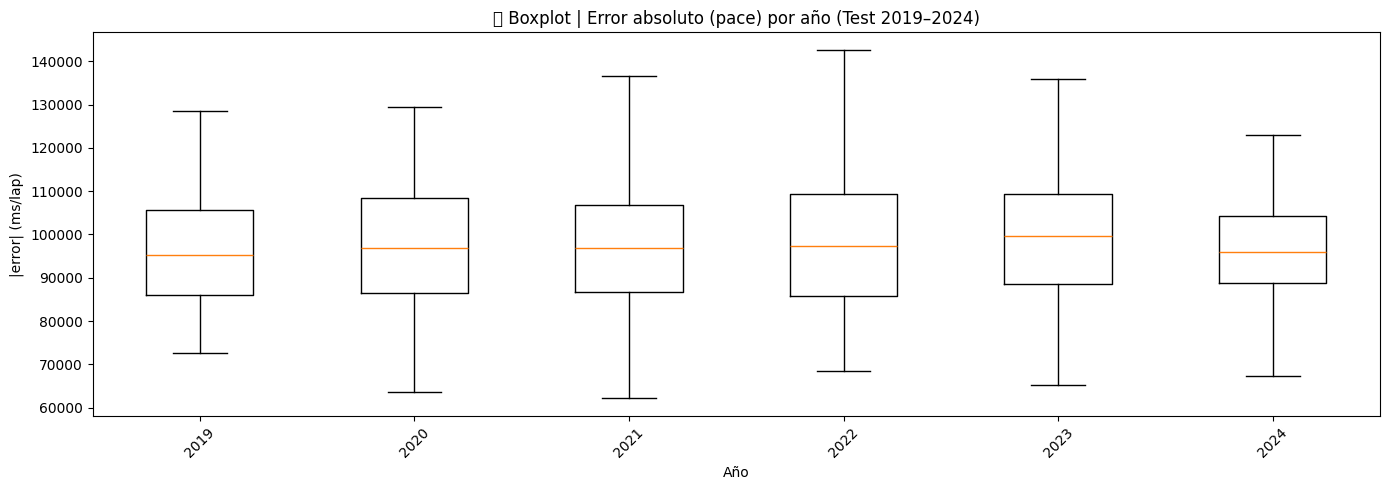

In [9]:
years = eval_df["year"].astype(int)

data = []
labels = []
for yr in sorted(years.unique()):
    v = eval_df.loc[eval_df["year"] == yr, "abs_err_pace"].values
    if len(v) >= 20:  # evitamos años con muy poca muestra
        data.append(v)
        labels.append(str(yr))

plt.figure(figsize=(14, 5))
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("📦 Boxplot | Error absoluto (pace) por año (Test 2019–2024)")
plt.xlabel("Año")
plt.ylabel("|error| (ms/lap)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\1507176903.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


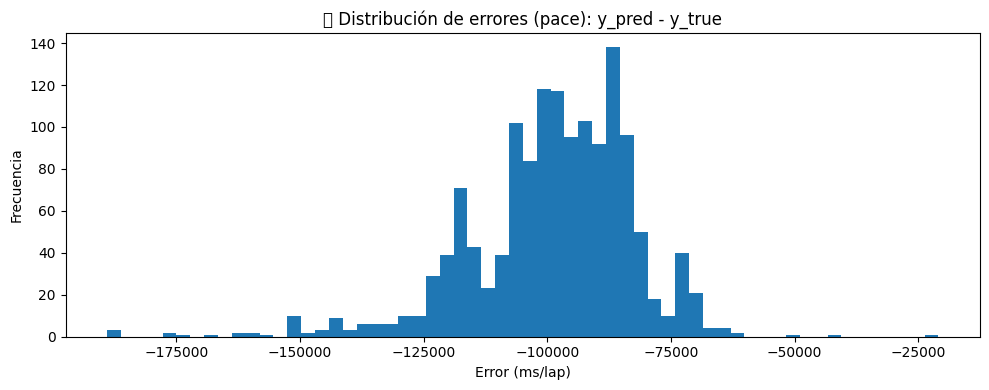

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\1507176903.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


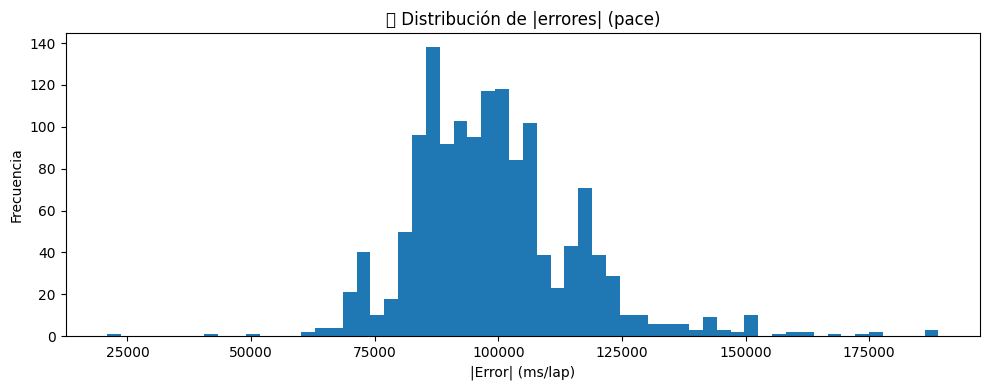

In [10]:
plt.figure(figsize=(10, 4))
plt.hist(eval_df["err_pace"].values, bins=60)
plt.title("📊 Distribución de errores (pace): y_pred - y_true")
plt.xlabel("Error (ms/lap)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(eval_df["abs_err_pace"].values, bins=60)
plt.title("📊 Distribución de |errores| (pace)")
plt.xlabel("|Error| (ms/lap)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_7316\205202484.py:7: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
d:\Programas\Codes for VS code\Proyecto_F1Kedro\proyecto_f1kedro\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


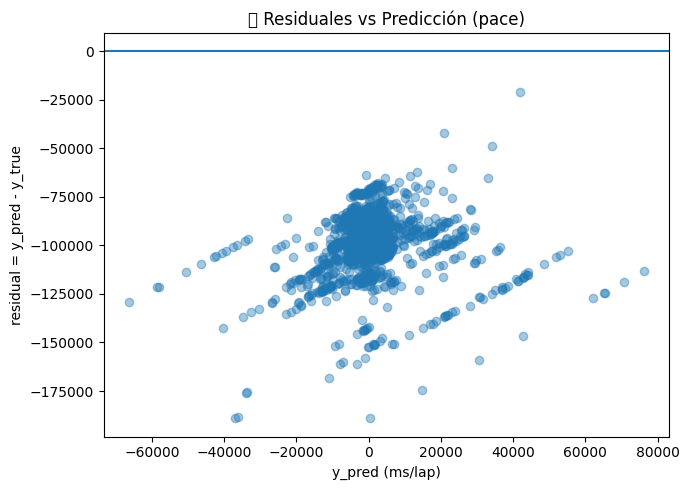

In [11]:
plt.figure(figsize=(7, 5))
plt.scatter(eval_df["y_pred_pace"], eval_df["err_pace"], alpha=0.4)
plt.axhline(0)
plt.title("🎯 Residuales vs Predicción (pace)")
plt.xlabel("y_pred (ms/lap)")
plt.ylabel("residual = y_pred - y_true")
plt.tight_layout()
plt.show()


In [12]:
grp = (
    eval_df.groupby("circuitId")["abs_err_pace"]
    .agg(["mean", "median", "count"])
    .sort_values("mean", ascending=False)
)

# Filtrar circuitos con muestra suficiente
grp = grp[grp["count"] >= 25]

worst = grp.head(15)
best = grp.tail(15)

worst, best


(                    mean         median  count
 circuitId                                     
 73         126807.188426  123657.190846     65
 77         125323.777873  117602.505428     53
 15         117475.868839  118352.517175     51
 13         116463.955870  116726.078408     60
 69         106490.435785  106434.809824     56
 71         105235.518565  104937.667573     36
 3          103641.884066  100508.335816     86
 9          102559.567103   99666.538576     96
 24         101968.379926  101138.652587     65
 80         101952.089339  101863.732803     33
 1          101352.330543   96046.149411     39
 34          98419.794722   99053.586210     32
 79          94475.778258   94229.312603     52
 14          91291.702172   89728.734519     80
 21          90021.183907   88492.845206     46,
                     mean         median  count
 circuitId                                     
 80         101952.089339  101863.732803     33
 1          101352.330543   96046.14941